# MSBI 31300 1 (Autumn 2023)

## Concepts in Programming, Final Project, Aditi Verma


### Final Project: Lumosity Data

Data Parse Adventure: Choose a large dataset. There are many freely available datasets out there, from science-related to movie ratings (movielens) to the fuel economy ratings of automobiles (fueleconomy.gov) and many, many more. Pick one that interests you. The dataset can be in Excel, raw text format, or something more exotic (databases!?) and start by getting familiar with the dataset. For your submission (up to -5 points if a given requirement is not fulfilled):

1. Include a description (~4-5 sentences) of the dataset content and its format (not just if in .csv or .txt, but also information on size, columns/tables/records/rows/etc. as appropriate. List the source information for it, including the URL. This is in addition to your readme! It’s okay to include it there, though.
2. Use appropriate packages, such as pandas and numpy. Briefly explain why these are needed. You don’t have to use pandas or numpy!
3. List at least three thoughtful questions, the answers to which you want to learn from the dataset. These questions should be specific. Parse and manipulate the dataset to respond to your questions. For each, list the question, your commented code, and the output in an easily readable format. (note that each question counts as a unique project requirement for the purposes of grading)
4. Come up with a theory, or prediction, related to the dataset that you can “test.” This should be sufficiently complex that it would take output or manipulation of more than one query on the data set to determine. a. Explain your theory or prediction, and a few sentences about how you plan to test it using the dataset. b. Show your commented code, and the output in an easily readable format. c. Include commentary on whether or not the dataset supported, refuted, or otherwise related to your theory.
5. Extra credit: use more than one dataset (+5 points).

## 1. Description of dataset:
This dataset consists of eight csv files, each containing scores for one battery of cognitive tests. Each battery of cognitive tests consists of a set of subtests and there are a total of 21 subtests. A detailed description of what type of cogntive abilities were tested in each subtest and which subtest comprise each battery can be found in Jaffe et al., Sci Data 2022. Briefly, these cognitive tasks test a variety of abilities, such as visual attention, working memory, grammatical reasoning, object recognition.and arithmetic reasoning.
Each csv file contains de-indentified data for multiple users. The data is in tabular format and the columns contain information on user_id, age, gender, education level, country, test run id, battery id, specific subtest id, raw score,  time of day,  grand index.
Each csv file for each battery has different row size: battery14: 47645; battery17: 416118; battery25: 36048; battery26: 14811; battery32: 851177; battery39: 1736195; battery50: 2302948; battery60: 46604. However, the number of columns is the same for all.
The data files can be found here: https://zenodo.org/records/7249732
The dataset was published here: https://www.nature.com/articles/s41597-022-01872-8
Here are the files: https://drive.google.com/drive/folders/1cHuPhwXHxqC4N3YuwEDOrrNAJajdW8KM?usp=share_link

## 2. Packages Used:
I have mainly used pandas and numpy for running this analysis because these packages offer a lot of functions to easily read and parse through tabular data. It is easy to look at basic attributes of the data using pandas, such min and max of columns and mean and standard deviation. I also used pandas to bin the age data which was otherwise difficult to handle due to the immense granularity. I have also used pandas to subset the data to answer different questions and to analyse parts of the data. In additon, I have used matplotlib and seaborn for visualization. I have used pingouin for some statistical analysis.

In [ ]:
#import all the packages:
import os 
import glob 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pingouin as pg
# Ignore FutureWarnings to improve code readability
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 3. At Least Three thoughful questions:
This piece of code has been designed in a way that quite a few questions can be asked from it. It is interactive and takes user input to analyse the data by education level or by binned age groups. The idea of designing this code is to let users query the data from all the eight datasets and understand how users perform for each of the subtests. However, it is also possible to look at the grand indices on the subsetted data using this code. Some questions this code can answer are
1. Do people with same education level perform similarly on different cognitive tests?
2. Do people in the same age group perform similarly on different cognitive tests?
3. Does the performance on cognitive tests for people at a higher education level also deteriorate with age similar to those with lower education level?

In [ ]:
#create a class that incorporates different types of analyses (as methods) that one may want to perform on this data
class Analysis:
    # Initialize the Analysis class with DataFrame, user input string that lets user choose between analysing by education levels or age groups, 
    # and numeric input which lets user select which particular education level or age range to analyse
    # these come from the functions created for handling user input below
    def __init__(self, df_2, user_input, numeric_input):
        self.df_2 = df_2
        self.str = user_input
        self.num = numeric_input
    
    # Method to generate a bar plot for the subsetted data grouped by subtest ids; 
    # these bar plots show the mean and standard deviations
    def barplot(self):
            subset_df = self.df_2[self.df_2[self.str].astype(str) == str(self.num)]#take user input and subset data
            if subset_df.empty:
                raise ValueError(f"No data available for {self.str} {self.num}") #if the subset data frame is empty inform the user
            
            #group the data by subtest id and get the means and standard deviations for each subtests
            level_data = subset_df.groupby('specific_subtest_id').percentage.agg([np.mean, np.std])
            #plot the horizontal bar plot with the mean and standard deviations
            return level_data.plot(kind="barh", y="mean", legend=False, title=f"{self.str} {self.num}", xerr="std")
    
    # Method to generate a table of aggregated data to be able to look at the actual values
    def table(self):
        #take user input and subset data
        subset_df = self.df_2[self.df_2[self.str].astype(str) == str(self.num)]
        if subset_df.empty:
            print(f"No data available for {self.str} {self.num}") #if the subset data frame is empty inform the user
            return None  # Return None or another value indicating no data
    
        #group the data by subtest id and get the means and standard deviations for each subtests
        level_data = subset_df.groupby('specific_subtest_id').percentage.agg([np.mean, np.std])
        return level_data #return the table
    
    # Method to perform ANOVA analysis
    def anova(self):
        #take user input and subset data
        subset_df = self.df_2[self.df_2[self.str].astype(str) == str(self.num)]
        if subset_df.empty:
            print(f"No data available for {self.str} {self.num}") #if the subset data frame is empty inform the user
            return None  # Return None or another value indicating no data
        
        # Perform ANOVA
        result = pg.anova(dv='percentage', between='specific_subtest_id', data=subset_df, detailed=True)
        return result

    # Method to generate a violin plot for grand index vs age range
    # BEWARE: this analysis would be irrelevant when the data has been filtered by age range already.
    # the plot then would have a single violin, nice sanity check for the code though
    def grandindex_age(self):
        #take user input and subset data
        subset_df = self.df_2[self.df_2[self.str].astype(str) == str(self.num)]
        if subset_df.empty:
            raise ValueError(f"No data available for {self.str} {self.num}") #if the subset data frame is empty inform the user
        
        # get the desired columns
        a = subset_df["age_range"]
        y = subset_df["grand_index"]
    
        # Create subplots, else multiple plots in the same cell get messed up
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
    
        # Violin plot using seaborn
        sns.violinplot(data=subset_df, x=a, y=y, ax=axes)
        axes.set_title(f"Violin Plot Age Range vs Grand Index- {self.str} {self.num}")#set the axes title
        
        plt.tight_layout()#Adjust the padding between and around subplots
        plt.show() #show the plot
    
    # Method to generate a violin plot for grand index vs education level
    # BEWARE: this analysis would be irrelevant when the data has been filtered by education level already.
    # the plot then would have a single violin, nice sanity check for the code though
    def grandindex_ed(self):
        #take user input and subset data
        subset_df = self.df_2[self.df_2[self.str].astype(str) == str(self.num)]
        if subset_df.empty:
            raise ValueError(f"No data available for {self.str} {self.num}") #if the subset data frame is empty inform the user
        # get the desired columns
        a = subset_df["education_level"]
        y = subset_df["grand_index"]
    
        # Create subplots
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
    
        # Violin plot
        sns.violinplot(data=subset_df, x=a, y=y, ax=axes)
        axes.set_title(f"Violin Plot Education Level vs Grand Index - {self.str} {self.num}")
        
        plt.tight_layout()#Adjust the padding between and around subplots
        plt.show()#show the plot
        
    # Method to generate a violin plot for grand index vs gender    
    def grandindex_gender(self):
        subset_df = self.df_2[self.df_2[self.str].astype(str) == str(self.num)]
        if subset_df.empty:
            raise ValueError(f"No data available for {self.str} {self.num}") #if the subset data frame is empty inform the user
        # Extract relevant columns
        a = subset_df["gender"]
        y = subset_df["grand_index"]
    
        # Create subplots
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
        
        # Violin plot
        sns.violinplot(data=subset_df, x=a, y=y, ax=axes)
        axes.set_title(f"Violin Plot Gender vs Grand Index- {self.str} {self.num}")
        
        plt.tight_layout()#Adjust the padding between and around subplots
        plt.show()#show the plot
                      
# defining a function to load and process data       
def load_data():
    file_path = input("Enter a file path: ") #ask user for path to folder containing the files
    if os.path.exists(file_path): #check if the path is correct
        csv_files = glob.glob(os.path.join(file_path, "*.csv")) #read the csv files in the folder
        df = pd.concat((pd.read_csv(f) for f in csv_files)) # concatanate the 8 csv files to merge data from all batteries in 1 data frame
        df_2 = df.dropna() #remove NAs
        return df_2  # Return the loaded and processed DataFrame
    else:
        print('The given file path does not exist') # tell the user if file path is not correct
        return None  # Return None to indicate failure

# Defining a function to interactively display data analysis options
def display():
    df_2 = load_data() #get the data frame from the previously defined load data function
    if df_2 is not None: # check if data frame was indeed loaded
        #ask user to use between analysisng by education level or age
        user_input = input("Choose 1 to analyze by education level and 2 to analyze by age: ")
        try: #to ensure that the user input is only 1 or 2 and nothing else
            if user_input == "1": # setting things up for analysing by education level
                str_input = "education_level"
                #convert the input to float
                num_input = float(input("Enter the education level (between 1 and 8, inclusive) that you wish to get the data for: "))
                # add a column to the data frame with the age bins
                df_2.loc[:,"age_range"] = pd.cut(df_2["age"], [10,20,30,40,50,60,70,80,90], labels = ["10-19","20-29","30-39","40-49","50-59","60-69","70-79","80-89"])
                # add a column to the data frame with normalised scores so that scores can be compared for different
                # subtests; this is because different subtests have a different scale of raw scores so
                # if a group performs similarly on different subtests cannot be compared without normalization to percentages
                df_2.loc[:,"percentage"] = 100 * df_2["raw_score"] / df_2.groupby("specific_subtest_id")["raw_score"].transform("max")
            elif user_input == "2":
                str_input = "age_range"
                num_input = input("Enter the age range (choose from: 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80-89) that you wish to get the data for: ")
                # add a column to the data frame with the age bins
                df_2.loc[:,"age_range"] = pd.cut(df_2["age"], [10,20,30,40,50,60,70,80,90], labels = ["10-19","20-29","30-39","40-49","50-59","60-69","70-79","80-89"])
                df_2.loc[:,"percentage"] = 100 * df_2["raw_score"] / df_2.groupby("specific_subtest_id")["raw_score"].transform("max")
            else:
                raise ValueError("Please only input 1 or 2")
            # create an instance of the Analysis class for further analysis
            return Analysis(df_2, str_input, num_input)
        # Handle exceptions and display an error message
        except (ValueError, TypeError, AttributeError) as e:
            print(f"Error: {e}")
            return None

# get the Analysis instance from the display function
t = display()
# check if the Analysis instance is valid (not None)
if t:
    t.barplot() # display a horizontal bar plot of mean percentages
    print(t.table()) # display a table of mean and standard deviation of percentages
    print(t.anova()) # perform ANOVA analysis and print the results
    t.grandindex_age() # display a violin plot of Age Range vs Grand Index
    t.grandindex_ed() # display a violin plot of Education Level vs Grand Index
    t.grandindex_gender() # display a violin plot of Gender vs Grand Index

## 3.1. Do people with same education level perform similarly on different cognitive tests?

Enter a file path:  /Users/aditiverma/Library/Mobile Documents/com~apple~CloudDocs/UChicago_Q1/ConceptsInProg/Final Project/files
Choose 1 to analyze by education level and 2 to analyze by age:  1
Enter the education level (between 1 and 8, inclusive) that you wish to get the data for:  8


                          mean        std
specific_subtest_id                      
26                   31.839859   5.514027
27                   68.371795   8.314681
28                   45.917118   9.094882
29                   34.731034  10.915737
30                   24.421261  11.720794
31                   57.132587  19.859122
32                   33.002663   6.012757
33                   41.587188   8.929948
36                   82.598039  15.489210
37                   74.754902  19.153445
38                   62.706441  13.483205
39                    4.233440   1.923168
40                   14.868945   8.213610
43                   35.691635  11.352031
44                   32.195451  11.056732
45                   34.946658   7.985508
51                   44.119119  21.788635
52                   97.954955   6.648291
53                    8.756971   7.194390
54                   82.965465   9.827634
55                   81.813814   9.036815


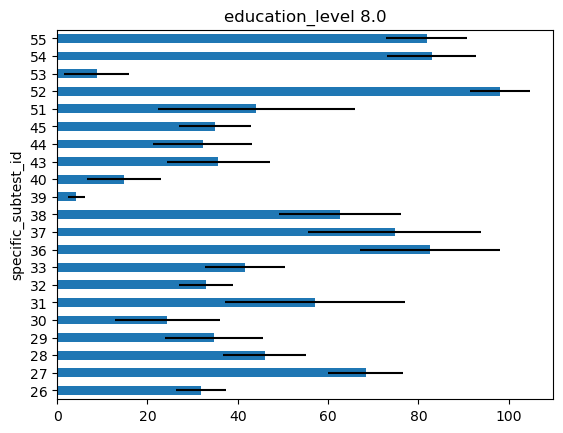

In [15]:
## check for education level 8
# get the Analysis instance from the display function
t = display()
# check if the Analysis instance is valid (not None)
if t:
    t.barplot() # display a horizontal bar plot of mean percentages
    print(t.table()) # display a table of mean and standard deviation of percentages
    
#user input:
# Enter a file path:  /Users/aditiverma/Library/Mobile Documents/com~apple~CloudDocs/UChicago_Q1/ConceptsInProg/Final Project/files
# Choose 1 to analyze by education level and 2 to analyze by age:  1
# Enter the education level (between 1 and 8, inclusive) that you wish to get the data for:  8

Enter a file path:  /Users/aditiverma/Library/Mobile Documents/com~apple~CloudDocs/UChicago_Q1/ConceptsInProg/Final Project/files
Choose 1 to analyze by education level and 2 to analyze by age:  1
Enter the education level (between 1 and 8, inclusive) that you wish to get the data for:  1


                          mean        std
specific_subtest_id                      
26                   30.235371   5.175513
27                   67.932065   8.418282
28                   45.981872   9.208868
29                   30.099516  11.311668
30                   21.994042  11.942520
31                   52.695690  20.454301
32                   32.817216   6.110422
33                   41.024860   9.148404
36                   80.555556  16.137431
37                   66.666667  18.633900
38                   59.353345  13.193043
39                    4.459795   2.501908
40                   16.695453   9.483692
43                   35.414313  11.800794
44                   31.631540  11.460235
45                   33.169898   7.894494
51                   35.185185  21.108432
52                   97.796296   7.762098
53                    7.506614   6.043829
54                   80.200617   9.270681
55                   79.481481  10.047231


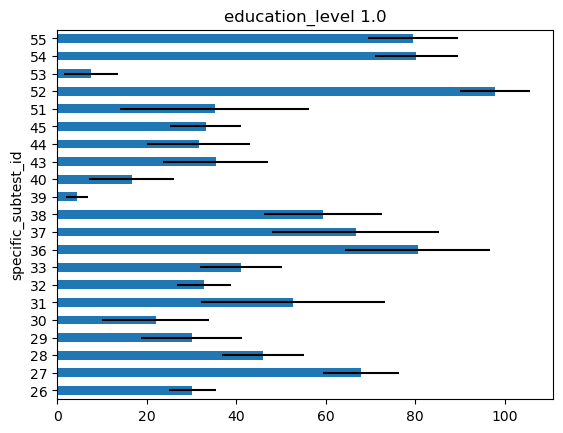

In [16]:
## check for education level 1
# get the Analysis instance from the display function
t = display()
# check if the Analysis instance is valid (not None)
if t:
    t.barplot() # display a horizontal bar plot of mean percentages
    print(t.table()) # display a table of mean and standard deviation of percentages
    
#user input:
# Enter a file path:  /Users/aditiverma/Library/Mobile Documents/com~apple~CloudDocs/UChicago_Q1/ConceptsInProg/Final Project/files
# Choose 1 to analyze by education level and 2 to analyze by age:  1
# Enter the education level (between 1 and 8, inclusive) that you wish to get the data for:  1

### 3.1 Inference: From the above two data pieces, it is clear that people with different education levels do not perform similarly on all tasks. People seem to perform too well ontask #52 (Posner Cueing) and poorly at task #39 (Trail making part A). Both highly educated individuals (level 8) and relatively less educated people (level 1) maintain the trend.

## 3.2. Do people in the same age group perform similarly on different cognitive tests?

Enter a file path:  /Users/aditiverma/Library/Mobile Documents/com~apple~CloudDocs/UChicago_Q1/ConceptsInProg/Final Project/files
Choose 1 to analyze by education level and 2 to analyze by age:  2
Enter the age range (choose from: 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80-89) that you wish to get the data for:  10-19


                          mean        std
specific_subtest_id                      
26                   29.884825   4.966751
27                   72.018359   8.187173
28                   51.219178   8.856903
29                   37.743277  12.763270
30                   28.768438  13.711286
31                   61.478835  20.287557
32                   29.808334   4.200770
33                   46.145225   9.303604
36                   75.757576  19.173674
37                   68.939394  21.518849
38                   72.807884  12.780272
39                    3.446684   1.091455
40                   11.666839   4.601396
43                   43.460128  10.682842
44                   38.900073  11.178442
45                   40.839161   8.384706
51                   58.908046  22.122136
52                   97.926108   6.489097
53                    8.787825   5.254105
54                   85.406404   9.475142
55                   85.182266   8.359573


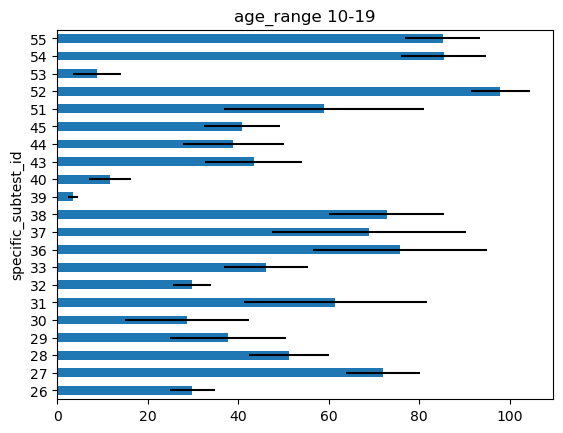

In [17]:
## check for age group 10-19 years
# get the Analysis instance from the display function
t = display()
# check if the Analysis instance is valid (not None)
if t:
    t.barplot() # display a horizontal bar plot of mean percentages
    print(t.table()) # display a table of mean and standard deviation of percentages
    
#user input:
# Enter a file path:  /Users/aditiverma/Library/Mobile Documents/com~apple~CloudDocs/UChicago_Q1/ConceptsInProg/Final Project/files
# Choose 1 to analyze by education level and 2 to analyze by age:  2
# Enter the education level (between 1 and 8, inclusive) that you wish to get the data for:  10-19

Enter a file path:  /Users/aditiverma/Library/Mobile Documents/com~apple~CloudDocs/UChicago_Q1/ConceptsInProg/Final Project/files
Choose 1 to analyze by education level and 2 to analyze by age:  2
Enter the age range (choose from: 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80-89) that you wish to get the data for:  80-89


                          mean        std
specific_subtest_id                      
26                   33.480717   9.743888
27                   61.895533   7.684451
28                   37.805830   8.170419
29                   26.631833   9.187724
30                   17.528303   9.448089
31                   47.645793  20.098310
32                   40.504980   7.786830
33                   34.768136   7.537066
36                   70.833333  17.677670
37                   41.666667  23.570226
38                   42.760133   9.452171
39                    6.182441   3.531982
40                   26.141702  15.660372
43                   23.117983   9.874968
44                   21.549468   9.447197
45                   23.497736   5.296567
51                   33.516484  17.257045
52                   95.824176  12.305007
53                    5.631868   3.470019
54                   76.950549  10.927807
55                   71.846154  10.910671


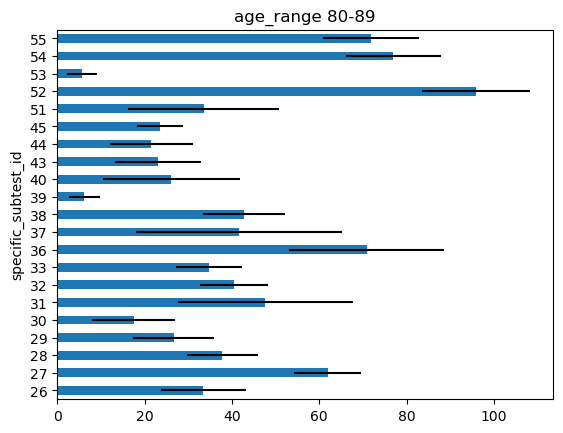

In [18]:
## check for age group 80-89 years
# get the Analysis instance from the display function
t = display()
# check if the Analysis instance is valid (not None)
if t:
    t.barplot() # display a horizontal bar plot of mean percentages
    print(t.table()) # display a table of mean and standard deviation of percentages
    
#user input:
# Enter a file path:  /Users/aditiverma/Library/Mobile Documents/com~apple~CloudDocs/UChicago_Q1/ConceptsInProg/Final Project/files
# Choose 1 to analyze by education level and 2 to analyze by age:  2
# Enter the education level (between 1 and 8, inclusive) that you wish to get the data for:  80-89

### 3.2 Inference: From the above two data pieces, it is clear that people in different age groups do not perform similarly on all tasks. The difference is not as stark as in education level but people seem to perform too well ontask #52 (Posner Cueing) and poorly at task #39 (Trail making part A). The performance in the older age group seems to have been consistently become poorer on most tasks; however, they continue to do well on tast 52.

## 3.3. Does the performance on cognitive tests for people at a higher education level also deteriorate with age similar to those with lower education level?

Enter a file path:  /Users/aditiverma/Library/Mobile Documents/com~apple~CloudDocs/UChicago_Q1/ConceptsInProg/Final Project/files
Choose 1 to analyze by education level and 2 to analyze by age:  1
Enter the education level (between 1 and 8, inclusive) that you wish to get the data for:  8


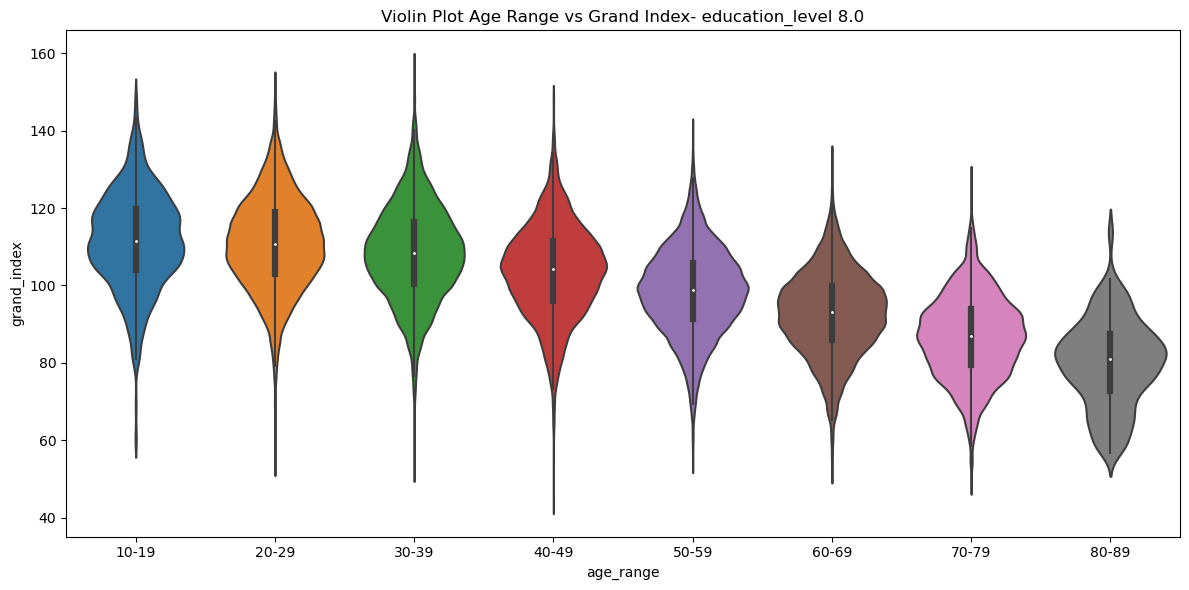

In [21]:
## check for education level 8
# get the Analysis instance from the display function
t = display()
# check if the Analysis instance is valid (not None)
if t:
    t.grandindex_age() # display a violin plot of Age Range vs Grand Index
    
#user input:
# Enter a file path:  /Users/aditiverma/Library/Mobile Documents/com~apple~CloudDocs/UChicago_Q1/ConceptsInProg/Final Project/files
# Choose 1 to analyze by education level and 2 to analyze by age:  1
# Enter the education level (between 1 and 8, inclusive) that you wish to get the data for:  8

Enter a file path:  /Users/aditiverma/Library/Mobile Documents/com~apple~CloudDocs/UChicago_Q1/ConceptsInProg/Final Project/files
Choose 1 to analyze by education level and 2 to analyze by age:  1
Enter the education level (between 1 and 8, inclusive) that you wish to get the data for:  1


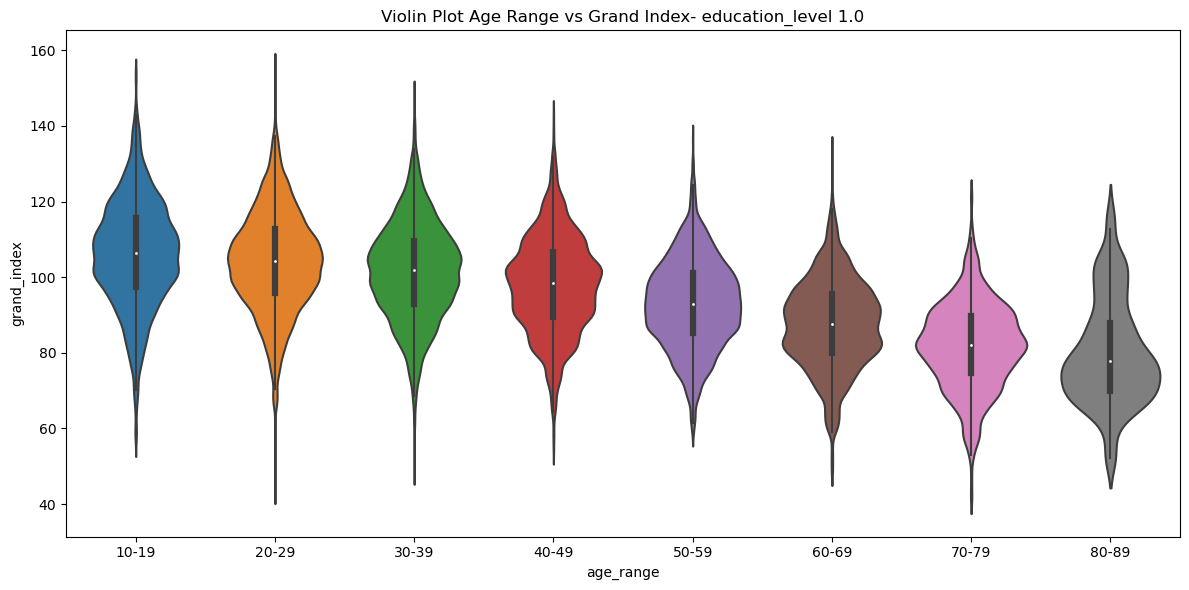

In [20]:
## check for education level 1
# get the Analysis instance from the display function
t = display()
# check if the Analysis instance is valid (not None)
if t:
    t.grandindex_age() # display a violin plot of Age Range vs Grand Index
    
#user input:
# Enter a file path:  /Users/aditiverma/Library/Mobile Documents/com~apple~CloudDocs/UChicago_Q1/ConceptsInProg/Final Project/files
# Choose 1 to analyze by education level and 2 to analyze by age:  1
# Enter the education level (between 1 and 8, inclusive) that you wish to get the data for:  1

### 3.3 Inference: From the above two data pieces, it seems like a higher education level does not save an individual from cognitive decline. Both the education level 1 and level 8 individuals seem to show a similar trend of decline. More statistical analysis is definitely needed on this data to make a robust comparison but from the looks of the plots there seems to be no difference in the way the two groups suffer from cognitive decline.

## 4. Testable Hypothesis:
Hypothesis: Overall cognition is related to age, education level and gender. That cognitive abilities decline with increasing age is not really a novel hypothesis; however, testing this hypothesis with the datasets here will serve as sort of a positive control showing that the cognitive tests in these datasets were appropriate and performed accurately. It would also be interesting to see if this indeed checks out. Further, it would be interesting to see if education level and gender have a role to play in cognitive performance.

To check this hypothesis, I have performed the analysis on data from each battery, one battery at a time. The grand index, which is a combined performance score for all the subtests in each battery, has been plotted against age, education level, and gender in three different violin plots for each battery. Violin plots give a good idea of the distribution of the data in addition to showing the mean value. This gives a very good visual representation of how the grand indexes change with age, education level and gender for each battery.

---------------------
---------------------------------
---------------------------------
---------------------------------
---------------------------------
Analysis for battery14_df.csv
   user_id   age gender  education_level country  test_run_id  battery_id  \
0     3127  30.0      m              NaN      US       393768          14   
1     3127  30.0      m              NaN      US       393768          14   
2     3127  30.0      m              NaN      US       393768          14   
3     3127  30.0      m              NaN      US       393768          14   
4     3127  30.0      m              NaN      US       393768          14   

   specific_subtest_id  raw_score  time_of_day  grand_index  
0                   29       16.0           12   123.633503  
1                   28        7.0           12   123.633503  
2                   30        7.0           12   123.633503  
3                   27       10.0           12   123.633503  
4                   26      381.0      

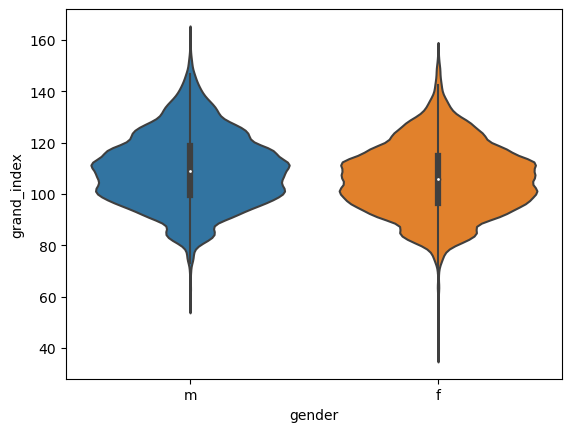

The basic description of data on grand indexes as grouped by different ages is as below:
       count        mean        std         min         25%         50%  \
age                                                                       
18.0  3045.0  110.496640  13.688864   75.270661  100.766931  110.853117   
19.0  2920.0  111.427701  13.110484   69.199587  102.268268  111.525490   
20.0  2805.0  110.971266  14.335572   38.223598  100.766931  111.184720   
21.0  2760.0  110.093082  13.019177   78.981486  100.364129  109.271285   
22.0  2585.0  111.279890  14.389995   64.981717  100.870599  110.511458   
...      ...         ...        ...         ...         ...         ...   
81.0     5.0   90.241187   0.000000   90.241187   90.241187   90.241187   
82.0    10.0  111.148964   9.361075  102.268268  102.268268  111.148964   
86.0    10.0   83.271361  27.246136   57.423406   57.423406   83.271361   
89.0     5.0  108.598995   0.000000  108.598995  108.598995  108.598995   
90.0    15.

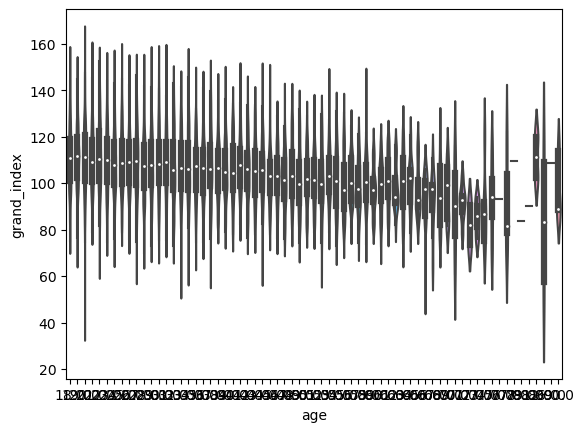

The basic description of data on grand indexes as grouped by different education_levels is as below:
                   count        mean        std        min         25%  \
education_level                                                          
1.0               2245.0  104.947857  13.142994  64.307513   95.344043   
2.0               8805.0  106.386148  13.527509  54.211214   97.027935   
3.0              13095.0  108.453452  14.010294  38.223598   98.506270   
4.0              10295.0  109.785633  14.289040  64.981717  100.206109   
5.0               3025.0  106.882077  13.678790  72.994029   97.894671   
6.0               3930.0  107.145602  13.849057  57.423406   96.836180   
7.0                555.0  110.658233  11.354078  84.761698  101.780017   
8.0               2990.0  105.911031  13.472602  69.199587   96.176754   

                        50%         75%         max  
education_level                                      
1.0              104.298741  113.200241  155.39093

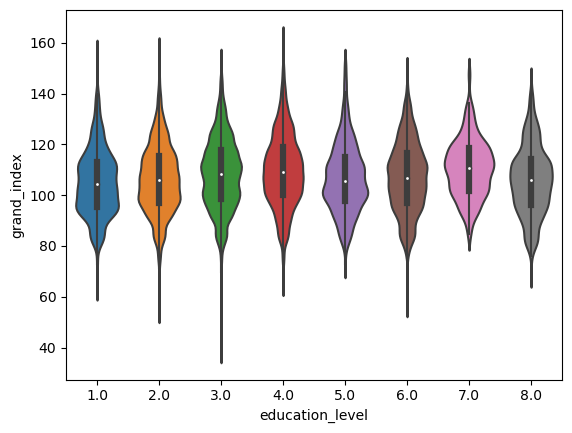

---------------------------------
---------------------------------
---------------------------------
---------------------------------
End of analysis for battery14_df.csv
---------------------
---------------------------------
---------------------------------
---------------------------------
---------------------------------
Analysis for battery17_df.csv
   user_id   age gender  education_level country  test_run_id  battery_id  \
0     1356  59.0      f              4.0      US          312          17   
1     1356  59.0      f              4.0      US          312          17   
2     1356  59.0      f              4.0      US          312          17   
3     1356  59.0      f              4.0      US          312          17   
4     1356  59.0      f              4.0      US          312          17   

   specific_subtest_id  raw_score  time_of_day  grand_index  
0                   29        8.0           17    89.751356  
1                   28        5.0           17    89

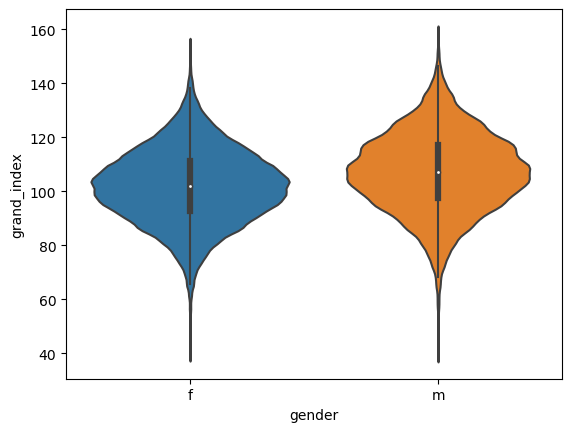

The basic description of data on grand indexes as grouped by different ages is as below:
       count        mean        std        min         25%         50%  \
age                                                                      
18.0  2730.0  112.588806  12.983874  57.018263  103.570221  112.316784   
19.0  3654.0  112.622533  13.555523  65.726286  103.873739  112.162378   
20.0  4710.0  112.665129  12.680785  72.384083  104.744266  113.113506   
21.0  5292.0  113.172858  12.308140  59.401829  105.036613  112.455588   
22.0  6066.0  113.023289  12.329596  71.653635  104.454764  112.804545   
...      ...         ...        ...        ...         ...         ...   
86.0   210.0   83.745063  11.466521  61.704220   73.864161   84.787104   
87.0   102.0   77.641179   9.758307  59.786240   72.215184   76.881778   
88.0    84.0   86.448235   7.069856  73.733912   79.727978   86.988575   
89.0    48.0   80.534347  11.801929  65.397425   71.285443   79.854434   
90.0   108.0   78.86142

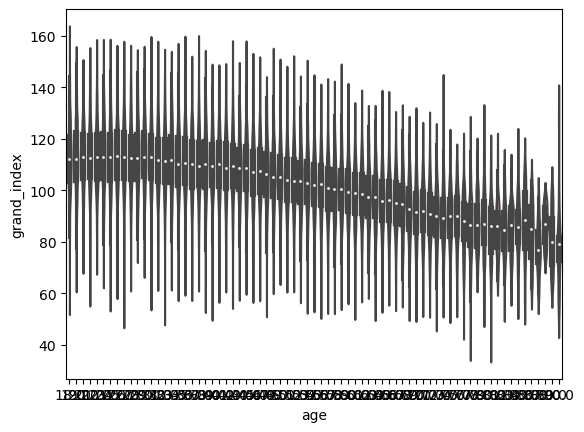

The basic description of data on grand indexes as grouped by different education_levels is as below:
                    count        mean        std        min        25%  \
education_level                                                          
1.0                5676.0   97.815789  14.246071  47.061268  88.188371   
2.0               31632.0   99.682433  14.156461  50.801558  90.171593   
3.0               77088.0  102.947018  14.452407  39.522446  93.349147   
4.0              117636.0  106.216108  14.078839  53.433724  96.904415   
5.0               26880.0  105.783309  14.182342  55.013049  96.549430   
6.0               63846.0  105.174412  13.980510  39.522446  95.762302   
7.0               10440.0  104.491578  14.344063  57.737201  94.707534   
8.0               21846.0  101.252932  13.433869  49.593163  92.225235   

                        50%         75%         max  
education_level                                      
1.0               97.842881  107.562365  146.16470

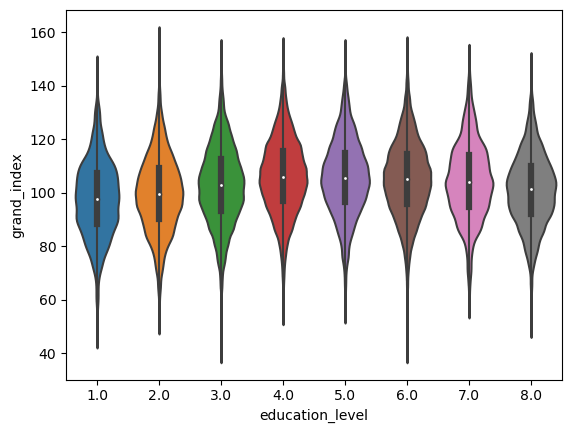

---------------------------------
---------------------------------
---------------------------------
---------------------------------
End of analysis for battery17_df.csv
---------------------
---------------------------------
---------------------------------
---------------------------------
---------------------------------
Analysis for battery25_df.csv
    user_id   age gender  education_level country  test_run_id  battery_id  \
0  14335196  30.0      m              4.0      US       626579          25   
1  14335196  30.0      m              4.0      US       626579          25   
2  17096000  53.0      f              5.0      US       653018          25   
3  17096000  53.0      f              5.0      US       653018          25   
4  17096000  53.0      f              5.0      US       653018          25   

   specific_subtest_id  raw_score  time_of_day  grand_index  
0                   29       36.0           13          NaN  
1                   28        8.0           13

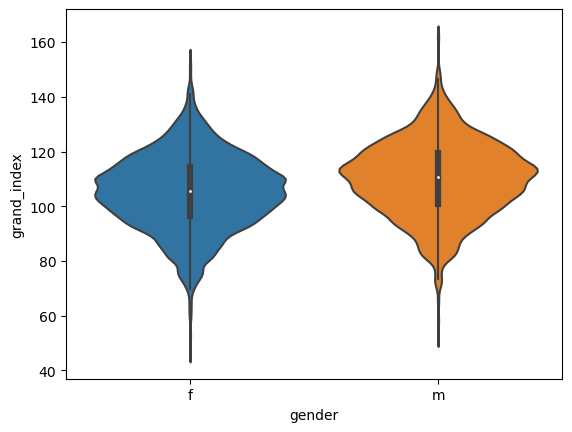

The basic description of data on grand indexes as grouped by different ages is as below:
       count        mean           std         min         25%         50%  \
age                                                                          
18.0   707.0  110.777872  1.199460e+01   83.091112  102.136190  109.114525   
19.0   847.0  111.623408  1.178811e+01   82.460655  104.080888  112.237953   
20.0   875.0  112.952762  1.172953e+01   82.354063  106.594820  112.957495   
21.0  1078.0  112.750325  1.140396e+01   80.556304  106.123470  112.613972   
22.0  1092.0  113.763529  1.217755e+01   82.795437  105.791543  113.057838   
...      ...         ...           ...         ...         ...         ...   
80.0    14.0   76.619049  1.768928e+00   74.914467   74.914467   76.619049   
81.0     7.0   87.857677  1.534948e-14   87.857677   87.857677   87.857677   
82.0    14.0   89.252465  6.393938e+00   83.091112   83.091112   89.252465   
86.0     7.0  113.311579  0.000000e+00  113.311579  1

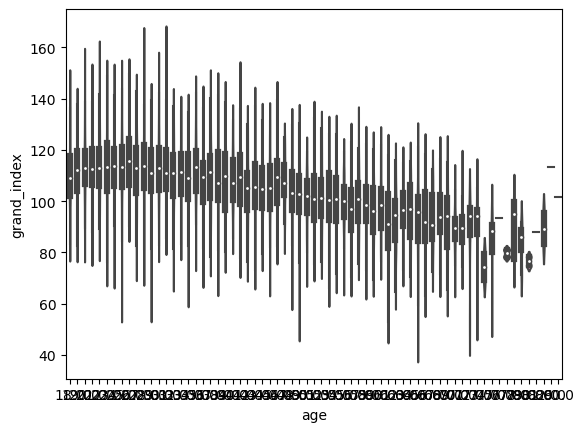

The basic description of data on grand indexes as grouped by different education_levels is as below:
                   count        mean        std        min         25%  \
education_level                                                          
1.0                686.0  102.666920  13.349992  64.247285   93.483370   
2.0               3584.0  101.927476  14.522499  52.828800   92.457005   
3.0               9156.0  106.502325  13.841766  46.942536   97.741554   
4.0              10829.0  109.369974  13.438891  64.575532  100.597619   
5.0               1988.0  109.488242  15.619585  57.360835   99.971179   
6.0               4697.0  108.562603  12.964508  59.506675  100.153681   
7.0                826.0  110.814823  13.929615  74.125614  102.392549   
8.0               1421.0  104.104085  12.965694  65.992684   94.296229   

                        50%         75%         max  
education_level                                      
1.0              104.147526  111.732101  130.01094

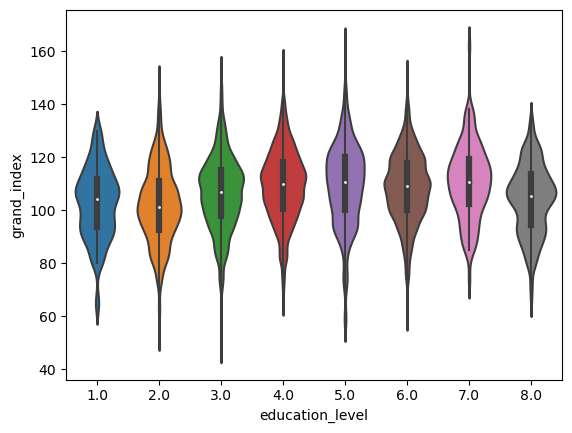

---------------------------------
---------------------------------
---------------------------------
---------------------------------
End of analysis for battery25_df.csv
---------------------
---------------------------------
---------------------------------
---------------------------------
---------------------------------
Analysis for battery26_df.csv
   user_id   age gender  education_level country  test_run_id  battery_id  \
0    68983  50.0      m              6.0      US       251259          26   
1    68983  50.0      m              6.0      US       251259          26   
2    68983  50.0      m              6.0      US       251259          26   
3    68983  50.0      m              6.0      US       251259          26   
4    68983  50.0      m              6.0      US       251259          26   

   specific_subtest_id  raw_score  time_of_day  grand_index  
0                   36       10.0           13   106.315883  
1                   39       19.0           13   106

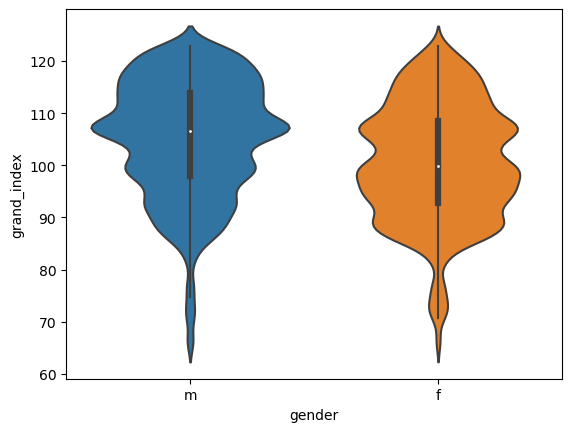

The basic description of data on grand indexes as grouped by different ages is as below:
      count        mean           std        min         25%         50%  \
age                                                                        
18.0  154.0  105.767550  1.087223e+01  86.476754   95.986067  106.720893   
19.0  176.0  100.240316  1.051091e+01  82.364517   93.453262   99.926731   
20.0  154.0  108.738333  1.044325e+01  88.606666   98.686866  108.129237   
21.0  286.0  108.327961  9.043512e+00  89.254566   99.926731  109.803902   
22.0  264.0  110.320327  9.913892e+00  85.546182  104.550920  111.960761   
...     ...         ...           ...        ...         ...         ...   
77.0   11.0   71.649712  0.000000e+00  71.649712   71.649712   71.649712   
78.0   22.0   84.855391  8.056016e+00  76.984596   76.984596   84.855391   
80.0   33.0   84.240641  1.318148e+01  66.239863   66.239863   90.125229   
81.0   11.0   92.407559  0.000000e+00  92.407559   92.407559   92.407559   

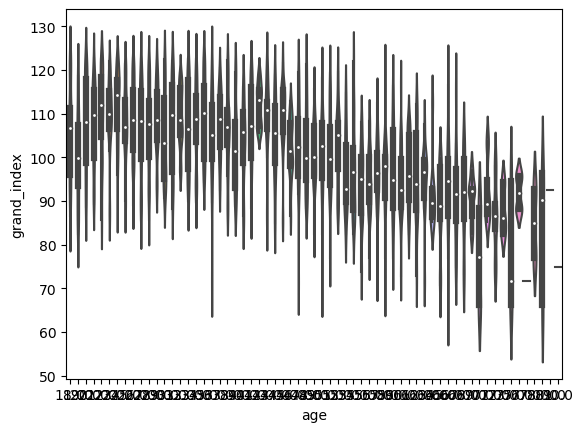

The basic description of data on grand indexes as grouped by different education_levels is as below:
                  count        mean        std        min        25%  \
education_level                                                        
1.0                99.0  102.637663  11.941903  86.476754  92.012319   
2.0              1078.0   98.336345  11.449639  70.688870  91.614518   
3.0              2662.0  101.790864  11.942979  66.239863  93.330215   
4.0              4400.0  103.899561  10.985193  70.688870  95.821976   
5.0               693.0  103.782164  10.935846  66.239863  95.651937   
6.0              2090.0  103.945434  10.208274  85.038671  96.750365   
7.0               242.0  100.179057  10.825984  71.649712  92.650084   
8.0               748.0  103.055509  13.302878  72.864453  91.744392   

                        50%         75%         max  
education_level                                      
1.0              104.201964  111.918125  120.109395  
2.0             

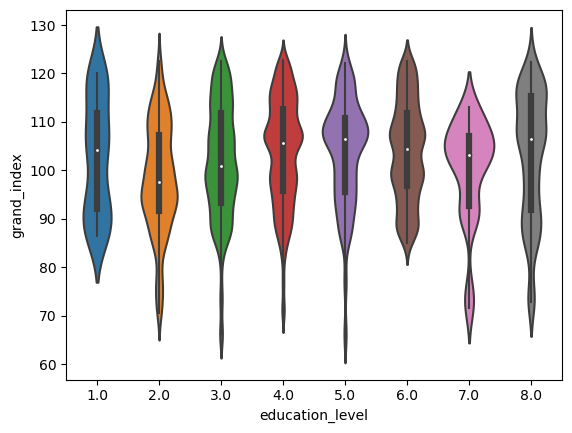

---------------------------------
---------------------------------
---------------------------------
---------------------------------
End of analysis for battery26_df.csv
---------------------
---------------------------------
---------------------------------
---------------------------------
---------------------------------
Analysis for battery32_df.csv
   user_id   age gender  education_level country  test_run_id  battery_id  \
0      183  68.0      m              6.0      US       668741          32   
1      183  68.0      m              6.0      US       668741          32   
2      183  68.0      m              6.0      US       668741          32   
3      183  68.0      m              6.0      US       668741          32   
4      183  68.0      m              6.0      US       668741          32   

   specific_subtest_id  raw_score  time_of_day  grand_index  
0                   29       17.0           15    92.668759  
1                   38       31.0           15    92

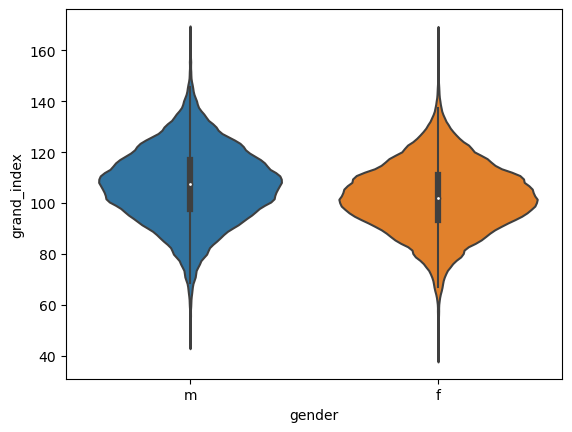

The basic description of data on grand indexes as grouped by different ages is as below:
        count        mean        std        min         25%         50%  \
age                                                                       
18.0   5931.0  110.830455  11.784562  69.339998  102.898025  111.491931   
19.0   9081.0  112.136185  12.120692  71.311220  104.076998  111.772473   
20.0  11484.0  112.769415  12.300167  74.993383  104.380903  112.603260   
21.0  12609.0  113.093111  12.521148  63.279079  104.840231  112.173978   
22.0  14679.0  113.459766  12.500278  50.613259  105.112428  113.227291   
...       ...         ...        ...        ...         ...         ...   
86.0    252.0   78.714606  10.408771  55.867417   70.561502   80.750146   
87.0    153.0   74.945819  12.573377  49.707684   66.051418   78.263141   
88.0    135.0   83.213964  10.275450  68.225295   72.308939   83.194941   
89.0     90.0   81.311923  12.574466  52.080512   73.648463   85.192747   
90.0    171

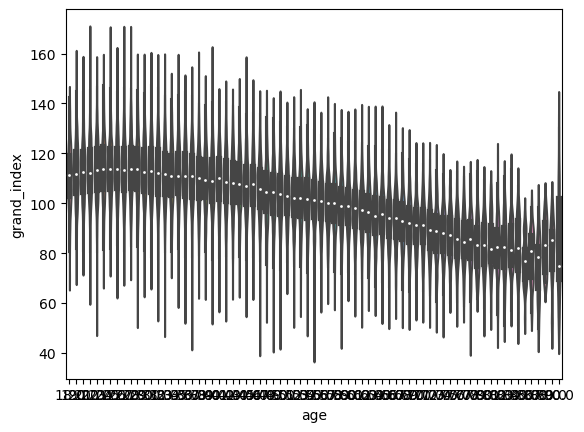

The basic description of data on grand indexes as grouped by different education_levels is as below:
                    count        mean        std        min        25%  \
education_level                                                          
1.0               11079.0   97.511251  14.034457  52.966593  87.874912   
2.0               63225.0  100.355870  14.018703  39.682431  91.154131   
3.0              157878.0  103.809818  14.286188  45.088822  94.334522   
4.0              234189.0  106.455744  13.993098  43.916615  97.222017   
5.0               53028.0  105.440964  13.865546  53.374493  96.331950   
6.0              122004.0  104.628618  13.797875  42.533545  95.441730   
7.0               19557.0  104.538260  14.093678  56.638205  95.116943   
8.0               35460.0  101.930435  13.666557  43.916615  93.153634   

                        50%         75%         max  
education_level                                      
1.0               97.663959  106.713819  149.39936

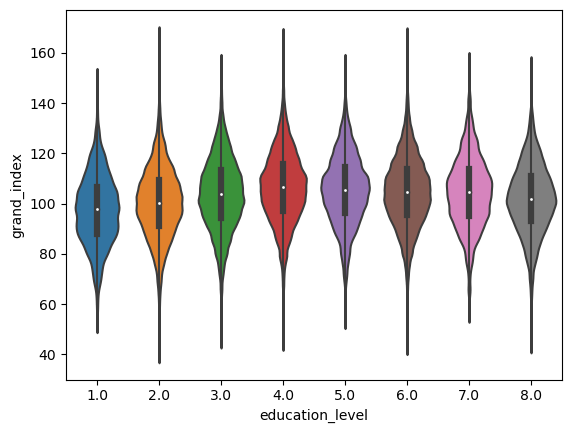

---------------------------------
---------------------------------
---------------------------------
---------------------------------
End of analysis for battery32_df.csv
---------------------
---------------------------------
---------------------------------
---------------------------------
---------------------------------
Analysis for battery39_df.csv
   user_id   age gender  education_level country  test_run_id  battery_id  \
0      622  23.0      f              5.0      US       323059          39   
1      622  23.0      f              5.0      US       323059          39   
2      622  23.0      f              5.0      US       323059          39   
3      762  58.0      f              5.0      US       407434          39   
4      762  58.0      f              5.0      US       407434          39   

   specific_subtest_id  raw_score  time_of_day  grand_index  
0                   29       22.0           19          NaN  
1                   38       51.0           19      

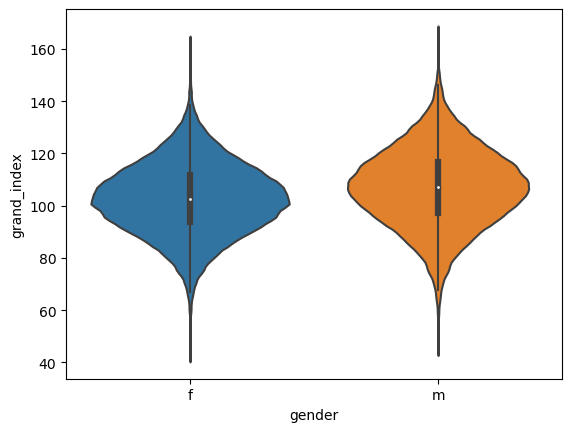

The basic description of data on grand indexes as grouped by different ages is as below:
        count        mean        std        min         25%         50%  \
age                                                                       
18.0  10000.0  112.322460  13.171421  65.587827  103.358632  112.554877   
19.0  15384.0  112.240446  12.800429  66.072966  104.072496  111.837538   
20.0  18912.0  112.292778  12.920893  57.783887  104.072496  112.415649   
21.0  22040.0  113.105514  12.767917  63.811093  104.484362  113.001996   
22.0  25440.0  113.718057  12.525269  59.394811  105.809009  113.734050   
...       ...         ...        ...        ...         ...         ...   
86.0    656.0   82.313239  10.996936  52.090555   75.965283   81.873918   
87.0    384.0   79.195490  10.279192  60.312842   74.185542   78.517747   
88.0    248.0   79.202424  12.981126  52.279131   70.528945   77.954407   
89.0    208.0   77.601859  14.733734  46.329535   68.531950   79.278901   
90.0    384

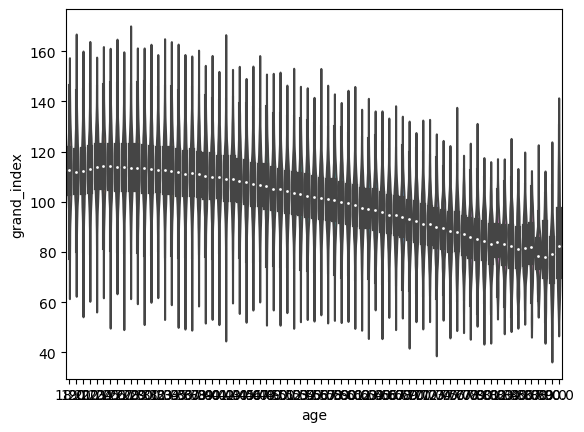

The basic description of data on grand indexes as grouped by different education_levels is as below:
                    count        mean        std        min        25%  \
education_level                                                          
1.0               22120.0   97.747566  14.390831  41.966843  87.993958   
2.0              127888.0   99.904411  14.043825  46.329535  90.647709   
3.0              311264.0  103.306950  14.329956  47.598133  93.696936   
4.0              487808.0  106.543508  14.082611  44.709308  97.212691   
5.0              106120.0  106.252534  14.066338  53.840387  96.771044   
6.0              251744.0  105.042537  13.937542  48.285274  95.587606   
7.0               39672.0  104.938736  14.471695  52.404032  95.153178   
8.0               72840.0  101.964241  13.492950  51.601916  92.911146   

                        50%         75%         max  
education_level                                      
1.0               98.115402  107.683532  153.21385

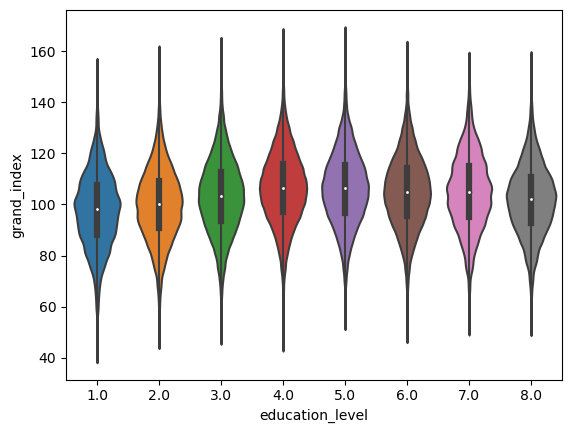

---------------------------------
---------------------------------
---------------------------------
---------------------------------
End of analysis for battery39_df.csv
---------------------
---------------------------------
---------------------------------
---------------------------------
---------------------------------
Analysis for battery50_df.csv
   user_id   age gender  education_level country  test_run_id  battery_id  \
0       29  69.0      m              4.0      US       100605          50   
1       29  69.0      m              4.0      US       100605          50   
2       29  69.0      m              4.0      US       100605          50   
3       29  69.0      m              4.0      US       100605          50   
4       29  69.0      m              4.0      US       100605          50   

   specific_subtest_id  raw_score  time_of_day  grand_index  
0                   29       14.0           22    87.413696  
1                   45       28.0           22    87

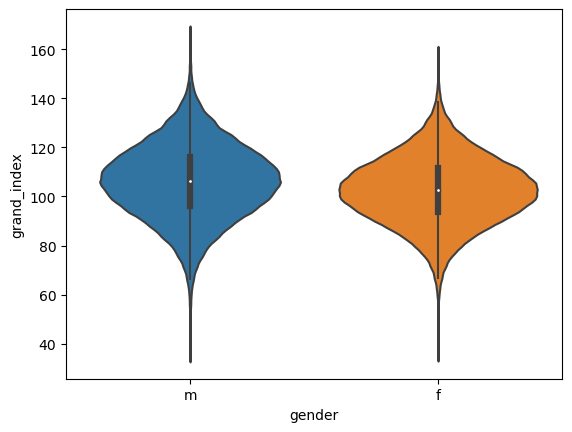

The basic description of data on grand indexes as grouped by different ages is as below:
        count        mean        std        min         25%         50%  \
age                                                                       
18.0  17104.0  111.896394  13.083977  60.628235  103.867340  111.717309   
19.0  23784.0  112.054405  13.151509  59.410458  103.583327  111.984334   
20.0  26304.0  112.569147  12.978866  49.600476  104.016858  112.501771   
21.0  29840.0  113.135601  12.512631  63.196736  104.574578  113.185727   
22.0  33648.0  113.167128  12.528209  56.863341  105.373796  112.904496   
...       ...         ...        ...        ...         ...         ...   
86.0    888.0   80.582449  12.454467  42.958468   73.641361   79.584046   
87.0    776.0   78.553945  12.972464  41.097612   70.658087   76.738239   
88.0    456.0   76.642331   9.947308  55.141140   70.511715   74.765511   
89.0    328.0   77.568977  12.905897  46.559119   68.469802   78.051398   
90.0    872

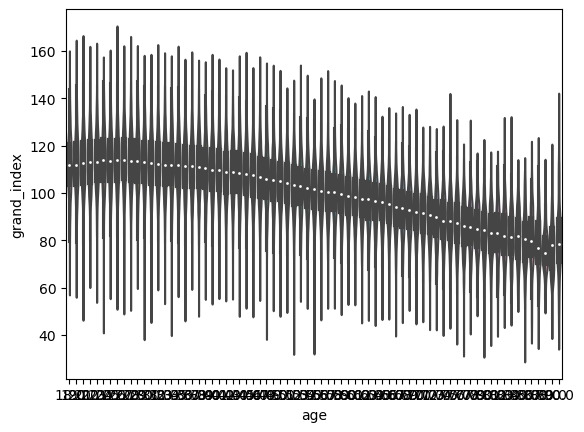

The basic description of data on grand indexes as grouped by different education_levels is as below:
                    count        mean        std        min        25%  \
education_level                                                          
1.0               35400.0   97.716492  14.789208  43.885476  87.568936   
2.0              188024.0   99.850469  14.193905  39.643365  90.527935   
3.0              433920.0  102.931986  14.554598  41.097612  93.130847   
4.0              659472.0  105.904747  14.158412  34.552308  96.520190   
5.0              147584.0  105.460945  14.254768  42.147839  95.945737   
6.0              352728.0  104.524552  13.939769  34.552308  95.378413   
7.0               56736.0  104.188222  14.724901  49.054446  94.380208   
8.0               93344.0  101.651711  13.524905  52.286796  92.712131   

                        50%         75%         max  
education_level                                      
1.0               98.061617  107.411548  153.08651

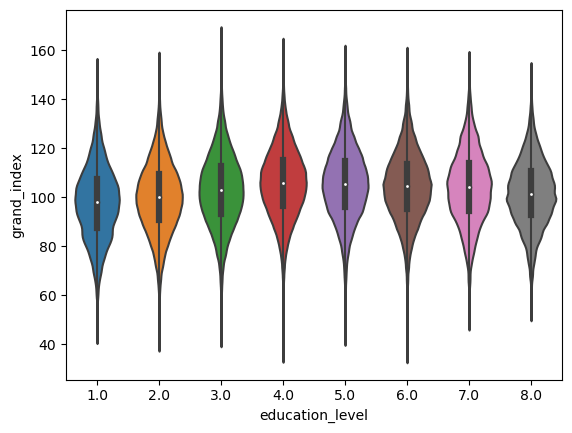

---------------------------------
---------------------------------
---------------------------------
---------------------------------
End of analysis for battery50_df.csv
---------------------
---------------------------------
---------------------------------
---------------------------------
---------------------------------
Analysis for battery60_df.csv
   user_id   age gender  education_level country  test_run_id  battery_id  \
0    11545  19.0      f              NaN      US       260583          60   
1    11545  19.0      f              NaN      US       260583          60   
2    11545  19.0      f              NaN      US       260583          60   
3    11545  19.0      f              NaN      US       260583          60   
4    11545  19.0      f              NaN      US       260583          60   

   specific_subtest_id  raw_score  time_of_day  grand_index  
0                   54       38.0           11   126.640354  
1                   52      100.0           11   126

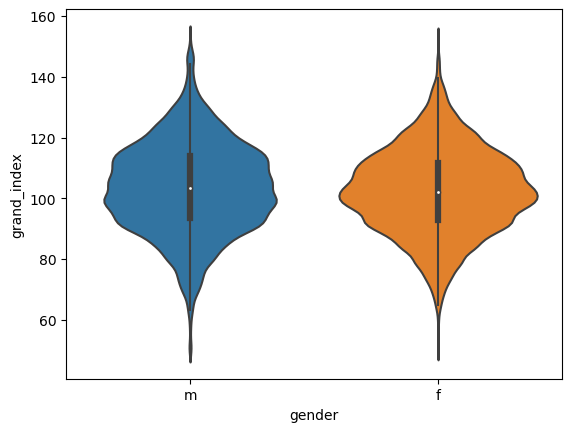

The basic description of data on grand indexes as grouped by different ages is as below:
      count        mean        std         min         25%         50%  \
age                                                                      
18.0  250.0  109.782061  11.903774   83.603902  100.998855  110.809781   
19.0  380.0  107.409978  15.197199   70.347486   97.733985  109.508912   
20.0  345.0  107.366593  14.910108   63.218621   99.270809  110.404365   
21.0  415.0  112.225467  13.518296   72.217322  102.973757  113.487377   
22.0  475.0  108.944278  13.737613   78.996114  100.191679  109.056559   
...     ...         ...        ...         ...         ...         ...   
86.0   30.0   83.574891  10.219993   65.991014   78.297938   83.851442   
87.0   35.0   84.641217  10.399383   73.158495   74.499659   81.793635   
88.0   20.0   82.577512  12.494742   63.773856   76.168050   85.470764   
89.0   10.0  104.754805   3.636834  101.304601  101.304601  104.754805   
90.0   45.0   90.105134

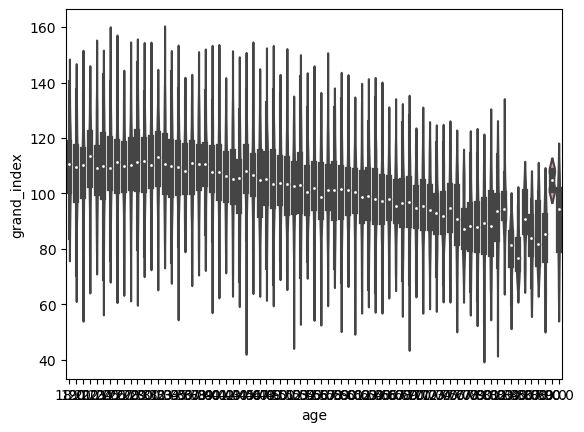

The basic description of data on grand indexes as grouped by different education_levels is as below:
                   count        mean        std        min        25%  \
education_level                                                         
1.0                810.0   94.829485  13.415506  62.241958  84.397026   
2.0               4045.0   97.470237  13.628782  50.524791  89.109438   
3.0               7735.0  100.973072  14.700354  50.524791  91.188677   
4.0              11900.0  104.830241  14.074681  50.524791  95.343539   
5.0               3040.0  104.046272  13.395980  68.117638  95.594666   
6.0               6400.0  104.830311  13.728077  50.524791  95.481644   
7.0               1030.0  104.879110  14.986098  67.796312  93.510594   
8.0               1665.0  101.513438  14.202116  61.196293  91.029942   

                        50%         75%         max  
education_level                                      
1.0               95.064381  104.293182  123.672945  
2.0   

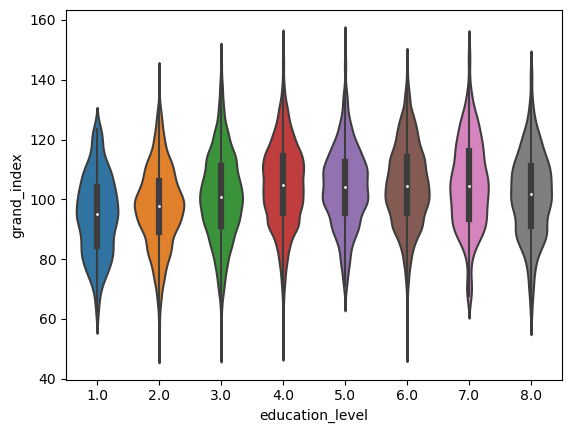

---------------------------------
---------------------------------
---------------------------------
---------------------------------
End of analysis for battery60_df.csv


In [11]:
# The code uses a for loop to go over all the eight csv files each pertaining to one test battery.

#make a list of file names for analysing one battery at a time
#this piece of code assumes that all the files are in the working directory
lst = ["battery14_df.csv", "battery17_df.csv", "battery25_df.csv", "battery26_df.csv", "battery32_df.csv", "battery39_df.csv", "battery50_df.csv", "battery60_df.csv"]

for i in lst:
    #add some dashes to make the data for each battery decipherable
    print ("---------------------")
    print("---------------------------------")
    print("---------------------------------")
    print("---------------------------------")
    print("---------------------------------")
    print ( "Analysis for " + i) #indicate which battery is being analysed
    
    #reading the files and checking if the data is of the right form:
    file = pd.read_csv(i) #pandas reads one csv at a time
    print(file.head()) # get a snapshot of the file to ensure the format is right
    print("The shape of the tabular data in this file is:" + str(file.shape)) #get the dimensions of the data frame
    print(file.info()) #ensure all the columns are of the correct data types
    file_2 = file.dropna() #remove all the NAs from the data frame
    print("The shape of the tabular data in this file after removing NAs is:" + str(file_2.shape)) 
    print(file_2.describe()) #get the basic stats for the numerical data in the dataset
    what99 = file_2[file_2["education_level"]<20] #remove the rows with education level more than 99, which is messing up the data and doesn't seem right
    #it is probably education_level 9 but wouldn't be safe to assume
    
    #grand index by age, gender, education level
    #gender
    print ("The basic description of data on grand indexes as grouped by different genders is as below:")
    print(what99.groupby("gender")["grand_index"].describe()) #group the data by gender and get the mean etc. for grand index
    #correlation and violin plot
    # define the comparison variables by subsetting the required columns
    y = what99["grand_index"]
    b = what99["gender"]
    #calculating the T test data for grand index vs gender
    male = what99[what99["gender"] == "m"].grand_index
    female = what99[what99["gender"] == "f"].grand_index
    res = stats.ttest_ind(female, male)
    print ("The t-Test data for correlation of grand index and gender is:")
    print(res)
    print ("Here's what grand index plotted against gender looks like:")
    sns.violinplot(data=what99, x=b, y=y)#gender vs grand index violin plot
    plt.show()
    
    #age
    print ("The basic description of data on grand indexes as grouped by different ages is as below:")
    print(what99.groupby("age")["grand_index"].describe()) #group the data by gender and get the mean etc. for grand index
    #correlation and violin plot
    # define the comparison variables by subsetting the required columns
    y = what99["grand_index"]
    a = what99["age"]
    #calculating the correlation data for grand index vs age
    res = stats.pearsonr(a, y)
    print ("The Pearson's correlation data for correlation of grand index and age is:")
    print(res)
    print ("Here's what grand index plotted against age looks like:")
    sns.violinplot(data=what99, x=a, y=y)#age vs grand index
    plt.show()
    
    
    #education level
    print ("The basic description of data on grand indexes as grouped by different education_levels is as below:")
    print(what99.groupby("education_level")["grand_index"].describe()) #group the data by gender and get the mean etc. for grand index
    #correlation and violin plot
    # define the comparison variables by subsetting the required columns
    y = what99["grand_index"]
    x = what99["education_level"]
    #calculating the correlation data for grand index vs education_levels
    res = stats.pearsonr(x, y)
    print ("The Pearson's correlation data for correlation of grand index and education_level is:")
    print(res)
    print ("Here's what grand index plotted against education_level looks like:")
    sns.violinplot(data=what99, x=x, y=y)#age vs grand index
    plt.show()
    # some more dashes to indicate the end of analysis of a particular battery
    print("---------------------------------")
    print("---------------------------------")
    print("---------------------------------")
    print("---------------------------------")
    print("End of analysis for " + i)

## 4. Inferences from the analysis: 
It is quite clear from the analyses of the different batteries that cognitive performance, as assessed by the grand indices, clearly declines for each battery as age of the participants increases. This is also clear from a significantly negative Pearson's correlation coefficient, which is around -0.5 for each battery
In case of gender, the correlation coefficent cannot be calculated as genders are non-numeric; however, from the plots, it seems like that there is not a great difference in the performance of the two genders in these tasks from the violin plots. But from the t-test results there seems to be a statistically significant difference in the way men and women perform at these tasks.
Finally, the affect of education level is most clear in battery 60, where the performace declines with low education level. This battery has more complex tasks including, complex memory span, object recognition, dual search and Posner cueing. It is interesting that individuals with less education level perform poorly on these more complex tasks.

## 5. Multiple Datasets:
Would using multiple large csv files count as using more than one dataset?